### BAYESIAN INFERENCES

In [1]:
import pymc3 as pm
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
from scipy.stats import gamma

In [2]:
insurance = pd.read_csv('insurance2.csv')
insurance.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


In [3]:
yes = insurance.charges[insurance.insuranceclaim == 1]
no = insurance.charges[insurance.insuranceclaim == 0]
ins = len(yes)
no_ins = len(no)

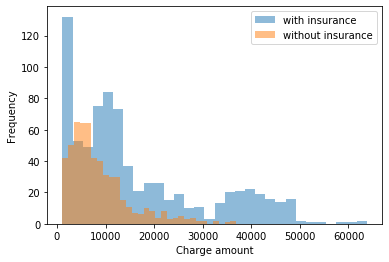

In [4]:
_ = plt.hist(yes, bins=30, alpha=0.5, label='with insurance')
_ = plt.hist(no, bins=30, alpha=0.5, label='without insurance')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

We may suspect from the above that there is some sort of exponential-like distribution at play here. The charges that were not insurance claims seem most like this. The insurance claim charges may possibly be multimodal. The gamma distribution may be applicable and we could test this for the distribution of charges that weren't insurance claims first. Developing our new method for the easiest looking case first is a common and sound approach that can demonstrate a minimum viable solution/product and get, or keep, stakeholders on board.

### Initial parameter estimation


In [8]:
alpha_est = np.mean(no)**2 / np.var(no)
beta_est = np.var(no) / np.mean(no)
alpha_est, beta_est

(1.8759059725250857, 4702.486170152821)

### Initial simulation

In [9]:
seed(38)
no_ins_model_rvs = gamma(alpha_est, scale=beta_est).rvs(no_ins)

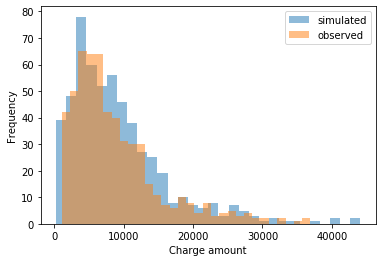

In [10]:
_ = plt.hist(no_ins_model_rvs, bins=30, alpha=0.5, label='simulated')
_ = plt.hist(no, bins=30, alpha=0.5, label='observed')
_ = plt.xlabel('Charge amount')
_ = plt.ylabel('Frequency')
_ = plt.legend()

Well it doesn't look too bad! We're not a million miles off. But can we do better? We have a plausible form for the distribution of charge amounts and potential values for that distribution's parameters so we can already draw random variates from that distribution to perform simulations. But we don't know if we have a best estimate for the population parameters, and we also only have a single estimate each for $\alpha$ and $\beta$; we aren't capturing our uncertainty in their values. Can we take a Bayesian inference approach to estimate the parameters?

### Creating a PyMC3 model

In [11]:
# PyMC3 Gamma seems to use rate = 1/beta
rate_est = 1/beta_est
# Initial parameter estimates we'll use below
alpha_est, rate_est

(1.8759059725250857, 0.00021265346963636093)

Q: You are now going to create your own PyMC3 model!
Use an exponential prior for alpha. Call this stochastic variable alpha_.
Similarly, use an exponential prior for the rate ($1/\beta$) parameter in PyMC3's Gamma. Call this stochastic variable rate_ (but it will be supplied as pm.Gamma's beta parameter). Hint: to set up a prior with an exponential distribution for $x$ where you have an initial estimate for $x$ of $x_0$, use a scale parameter of $1/x_0$.
Create your Gamma distribution with your alpha_ and rate_ stochastic variables and the observed data.
Perform 10000 draws.
Hint: you may find it helpful to work backwards. Start with your pm.Gamma, and note the required stochastic variables alpha and beta. Then, before that, you need to create those stochastic variables using pm.Exponential and the correct parameters.

In [12]:
with pm.Model() as model_no_ins:
    alpha_ = pm.Exponential("alpha", 1/alpha_est)
    rate_ = pm.Exponential("beta", 1/rate_est)
    
    chrage_no_ins = pm.Gamma("charge_no_insurance", alpha=alpha_, beta=rate_, observed=no)
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:17<00:00, 2382.23draws/s]
The acceptance probability does not match the target. It is 0.8869095581331619, but should be close to 0.8. Try to increase the number of tuning steps.


If you get a warning about acceptance probability not matching the target, and that it's around 0.88 when it should be close to 0.8, don't worry. We encourage you to read up on this and see if you can adjust the parameters and/or arguments to pm.sample, but if your model runs without any additional warnings or errors then you should be doing great!

In [13]:
alpha_samples = trace['alpha']
beta_samples = trace['beta']

In [14]:
cred_alpha = np.percentile(alpha_samples, [2.5, 97.5])
cred_beta = np.percentile(beta_samples, [2.5, 97.5])
print('95 percent credible interval for alpha: %f - %f' % (cred_alpha[0], cred_alpha[1]))
print('95 percent credible interval for beta: %f - %f' % (cred_beta[0], cred_beta[1]))

95 percent credible interval for alpha: 1.996517 - 2.484603
95 percent credible interval for beta: 0.000223 - 0.000285


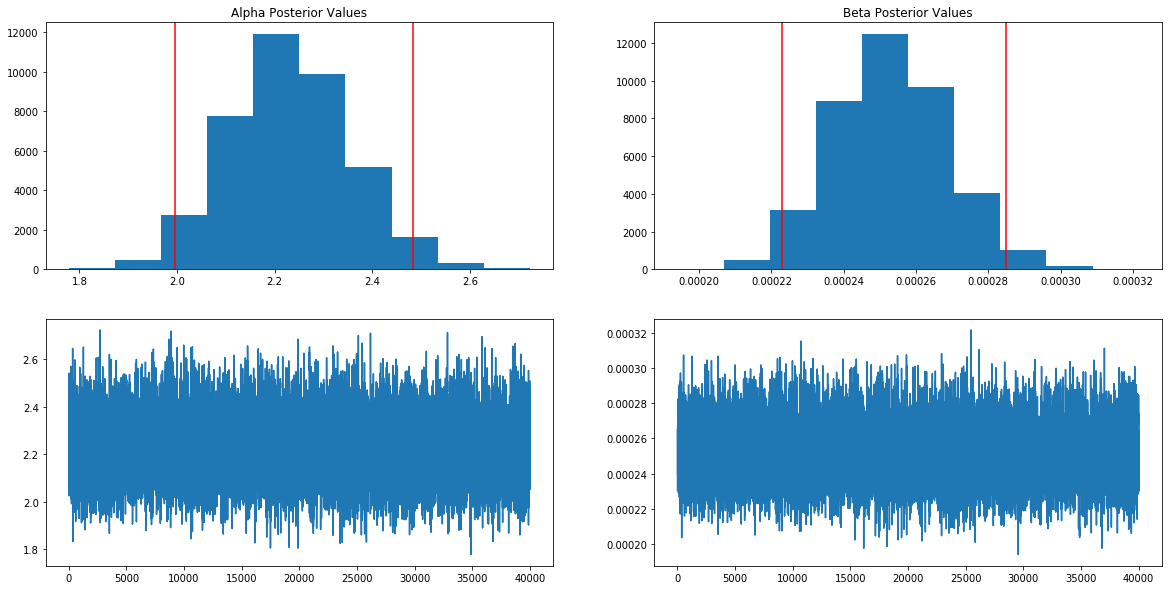

In [15]:
plt.figure(figsize=(20,10))

plt.subplot(221)
plt.hist(alpha_samples)
plt.axvline(x=cred_alpha[0], color='r')
plt.axvline(x=cred_alpha[1], color='r')
plt.title('Alpha Posterior Values')

plt.subplot(222)
plt.hist(beta_samples)
plt.axvline(x=cred_beta[0], color='r')
plt.axvline(x=cred_beta[1], color='r')
plt.title('Beta Posterior Values')

plt.subplot(223)
plt.plot(alpha_samples)

plt.subplot(224)
plt.plot(beta_samples)
plt.show()

Summary
In this exercise, we have postulated a distribution to describe the individual charge amounts for non-insured cases. This distribution has two required parameters, which we do not know, but we used PyMC3 to perform Bayesian inference to find our level of "belief" in a range of values for them. We then used the average parameter values to create one simulated data set of the same size as the original, but the distribution of our posteriors for these parameters will allow us to perform simulations of any sample size we desire and for a range of scenarios of different $\alpha$ and $\beta$. This could be a powerful tool to model different financial conditions for the hospital.
Well done making it through this tricky subject. Starting think Bayesian and starting to get to grips with something like PyMC3 is no easy task. As a data scientist, the most important thing is to be aware that this statistical approach exists, though you may not actually use this approach as much as you use the other approaches you've learned about. Still, we encourage you to think of ways that this approach could apply to the work that you do in this course and throughout your career.